**Dataset**
CheXpert chest x-ray dataset.

**Technique**
DenseNet for image classification. DenseNet is an open-source deep learning algorithm with implementations available in Keras (using TensorFlow as a back-end). Class Activation Maps are used to understand model activation and visualize it. DenseNet(Densely Connected Convolutional Networks) is one of the latest neural networks for visual object recognition. It’s quite similar to ResNet but has some fundamental differences.

**Tools and Platforms**
Deep Learning with GPU acceleration 
Cresle or GCP is used as a managed machine learning service for project management, run history and version control, and model deployment.

We use a weakly labelled dataset that was released by Stanford university. The dataset is described in this paper (https://arxiv.org/abs/1901.07031), and you can download it for free. It includes over more than 65,240 unique patients and 224,316 X-ray images with 14 different pathology labels (e.g. atelectasis, pneumonia, etc.) mined from radiology reports using NLP methods such as keyword search and semantic data integration. 

In [3]:
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [4]:
#!pip install densenet

In [20]:
#identify images path for future use
PATH = "/Users/My_Drive/Desktop/amliNet/Data"
#load the csv file to load targets
df = pd.read_csv(PATH + "/train.csv")
df = df.sample(1000)

In [21]:
# csv file has different image path, we change to math to our directory

def edit_urls(url):
    pieces = url.split('/')
    newurl=''
    for i, piece in enumerate(pieces):
        if i>0:
            newurl += '/' + piece
        elif i==0:
            newurl += PATH
    return newurl

Now let’s take a look at one of the images in our dataset to see what we are working with. We will plot the first image in our dataset and check its size using the ‘shape’ function.

/Users/My_Drive/Desktop/amliNet/Data/train/patient01199/study1/view2_lateral.jpg


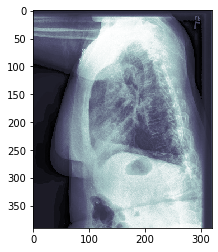

(320, 390)

In [36]:
#testing
tester_url = edit_urls(df.iloc[0]['Path'])
print( tester_url )
xray = Image.open(tester_url)
plt.imshow(xray, cmap="bone")
plt.show()

xray.size

In [5]:
#Change the path for all images
df["Path"] = df["Path"].apply(edit_urls)

Our dataset has a lot of NaN values, that are described as "no finding", we will fill them with zeros. Also, there are "m

In [6]:
#identify what features will be used for model training
outcomes = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'
]
#fill missing values with zeros, and assign all unsertain values (-1) to positive (1)
df[outcomes] = df[outcomes].fillna(0)
df[outcomes] = df[outcomes].replace(-1, 1)

In [7]:
#Train/test split
image_train, image_test, label_train, label_test = train_test_split(
   df['Path'], df[outcomes], test_size=0.2, random_state=42)

#Create train and test dataframes
train_df = pd.concat([image_train, label_train], axis=1)
test_df = pd.concat([image_test, label_test], axis=1)

#For the classifier to work, for some reason it has to be in string format
test_df['No Finding'] = test_df['No Finding'].apply(str)
train_df['No Finding'] = train_df['No Finding'].apply(str)

In [8]:
from keras.preprocessing.image import ImageDataGenerator


datagen=ImageDataGenerator(rescale=1./255,
                           samplewise_center=True,
                           samplewise_std_normalization=True,
                           shear_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           height_shift_range= 0.05,
                           width_shift_range=0.1,
                           fill_mode = 'reflect'
                           ) 

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='No Finding',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size = 16)

test_generator = datagen.flow_from_dataframe(
    test_df, 
    x_col='Path',
    y_col='No Finding',
    target_size=(256, 256),
    color_mode='grayscale', 
    batch_size=128)

Using TensorFlow backend.


Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


## BUILDING DenceNet MODEL

The model type that we will be using is Sequential. Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer. We use the ‘add()’ function to add layers to our model.

 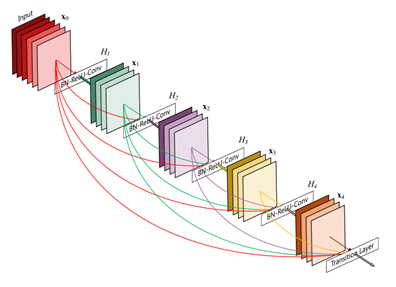 

DenseNet architecture 

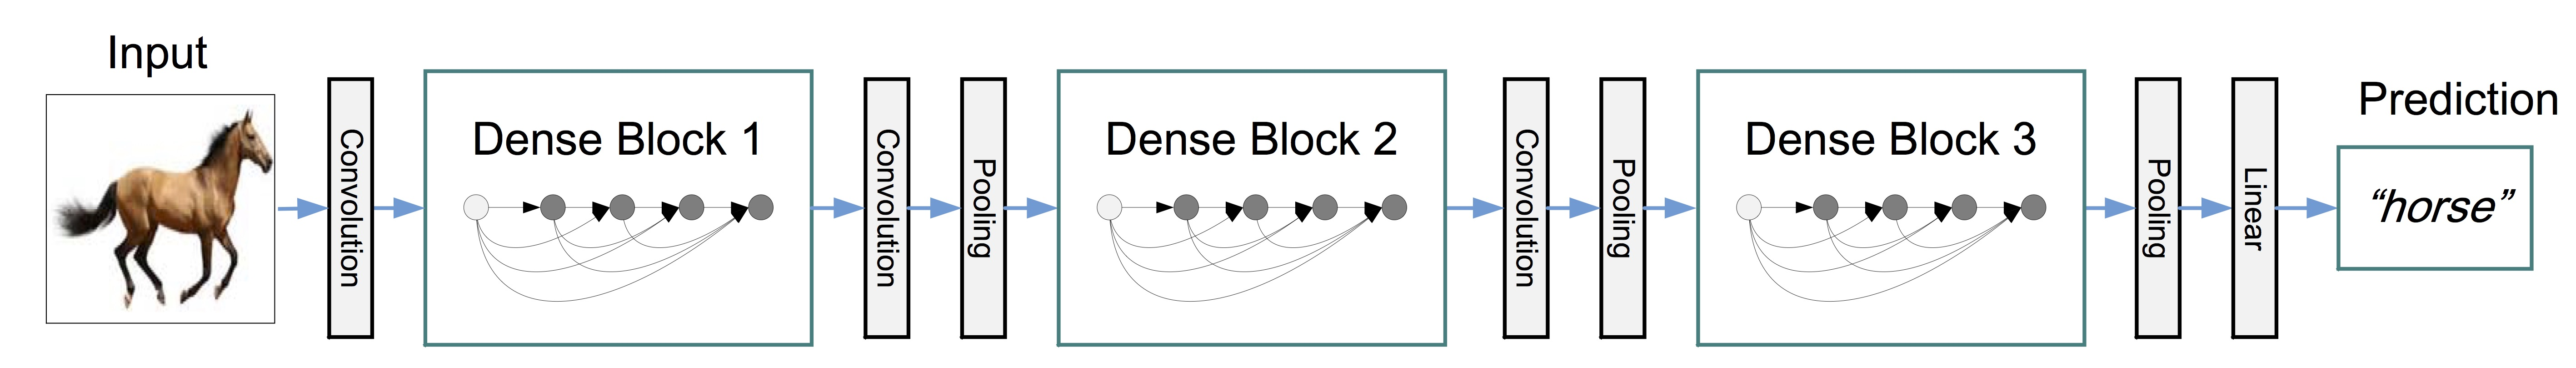

A deep DenseNet with three dense blocks

In [10]:
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tqdm import tqdm

model = densenet.DenseNet(classes=10, input_shape=(256, 256, 1), depth=40, growth_rate=12, bottleneck=True, reduction=0.5)
# or model = densenet.DenseNetImageNet121(input_shape=image_dim)

multi_model = Sequential()
multi_model.add(model)
multi_model.add(GlobalMaxPooling2D(name='globalMax'))
multi_model.add(Dropout(0.5, name='dropout1'))
multi_model.add(Dense(512, name='dense1'))
multi_model.add(Dropout(0.3, name='group2'))
multi_model.add(Dense(2, activation = 'softmax', name='finalsoftmax'))
multi_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'mae'])


In [11]:
multi_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20860904  
_________________________________________________________________
globalMax (GlobalMaxPooling2 (None, 2048)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 2048)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               1049088   
_________________________________________________________________
group2 (Dropout)             (None, 512)               0         
_________________________________________________________________
finalsoftmax (Dense)         (None, 2)                 1026      
Total params: 21,911,018
Trainable params: 21,856,490
Non-trainable params: 54,528
_____________________________________

In [12]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
weight_path="../Users/My_Drive/Desktop/amliNet/weights_best.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early]



In [ ]:
#multi_model.load_weights(weight_path)

In [15]:
multi_model.fit_generator(train_generator,
                    steps_per_epoch=32,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=5,
                    callbacks = callbacks_list)

Epoch 1/10
31/32 [============================>.] - ETA: 1:51 - loss: 0.7294 - acc: 0.8690 - mean_absolute_error: 0.1596
Epoch 00001: val_loss did not improve from 0.69644
32/32 [==============================] - 3577s 112s/step - loss: 0.7347 - acc: 0.8633 - mean_absolute_error: 0.1637 - val_loss: 0.6985 - val_acc: 0.1383 - val_mean_absolute_error: 0.5027
Epoch 2/10
31/32 [============================>.] - ETA: 17s - loss: 0.5966 - acc: 0.8468 - mean_absolute_error: 0.1628
Epoch 00002: val_loss did not improve from 0.69644
32/32 [==============================] - 669s 21s/step - loss: 0.6012 - acc: 0.8457 - mean_absolute_error: 0.1634 - val_loss: 0.7037 - val_acc: 0.1496 - val_mean_absolute_error: 0.5053
Epoch 3/10
22/32 [===================>..........] - ETA: 2:57 - loss: 0.7176 - acc: 0.8210 - mean_absolute_error: 0.1972

KeyboardInterrupt: 